# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [8]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [9]:
env = UnityEnvironment(file_name="C:/Users/anshmish/Desktop/Personal/Courses/DRLND/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [10]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [11]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Helper Method to Train the Agent

In [12]:
def trainAgent(agent, n_episodes=2000, timeout=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, score_window_size=100, solution_score=13.0):
    print('\nTraining agent ')
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=score_window_size)  # last 'score_window_size' scores for candidate solution
    eps = eps_start                    # initialize epsilon
    
    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(timeout):
            # Query agent for action
            action = agent.act(state)
            # Get feedback from environment
            env_info = env.step(action.item())[brain_name]             # send the action to the environment
            next_state = env_info.vector_observations[0]           # get the next state
            reward = env_info.rewards[0]                           # get the reward
            done = env_info.local_done[0]                          # see if episode has finished

            # Move the agent a step
            agent.step(state, action, reward, next_state, done)

            score += reward                                    # update the score
            state = next_state                                 # roll over the state to next time step
            if done:                                           # exit loop if episode finished
                break
        
        # Cache the scores and decay epsilon
        scores.append(score)
        scores_window.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        # Print episode results
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")

        # Print if solution score achieved
        if np.mean(scores_window)>=solution_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    
    print("\nTraining Completed!")
    return scores

### 3. Helper Method to Test the Agent

In [13]:
def testAgent():
    print("Testing the Agent")
    agent = Agent(state_size=state_size, action_size=action_size, seed=0, pretrainedWeightsFile='checkpoint.pth', train = False)
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state)                    # select an action
        env_info = env.step(action.item())[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    print("Score: {}".format(score))
    return score

### 4. Helper Method to Plot the Scores

In [14]:
def plotScores(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 5. Train the Agent


Training agent 
Episode 558	Average Score: 13.00
Environment solved in 458 episodes!	Average Score: 13.00

Training Completed!


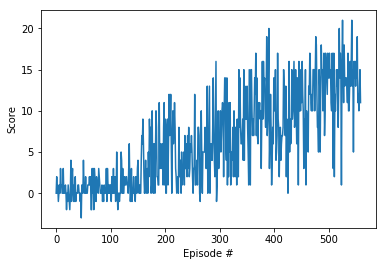

In [15]:
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = trainAgent (agent)
plotScores(scores)

### 6. Test the Agent

In [16]:
testAgent()

Testing the Agent
Score: 17.0


17.0